**Blok 1: Import Library**

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import copy
from collections import Counter
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.transforms import v2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


**Blok 2: Cek GPU dan Setup Device**

In [2]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
  current_device = torch.cuda.current_device()
  gpu_properties = torch.cuda.get_device_properties(current_device)
  print(f"GPU Name: {gpu_properties.name}")
  print(f"GPU Memory: {gpu_properties.total_memory / 1024**3:.2f} GB")
  print(f"GPU Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
else:
  print("No GPU available, using CPU")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.00 GB
GPU Compute Capability: 8.9

Using device: cuda


**Blok 3: Setup Path dan Parameters**

In [3]:
# Define dataset paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Check if directories exist
print("Checking dataset structure...")
if os.path.exists(train_dir) and os.path.exists(test_dir):
  train_classes = os.listdir(train_dir)
  test_classes = os.listdir(test_dir)
  print(f"Train classes: {train_classes}")
  print(f"Test classes: {test_classes}")
    
  # Count number of images per class
  print("\nNumber of images per class in train set:")
  for class_name in train_classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")

  print("\nNumber of images per class in test set:")
  for class_name in test_classes:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")
else:
  print(f"Error: Dataset directories not found!")
  print(f"Train directory: {train_dir}")
  print(f"Test directory: {test_dir}")

# Training parameters
batch_size = 64
num_epochs = 50
num_classes = 7

Checking dataset structure...
Train classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Number of images per class in train set:
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images

Number of images per class in test set:
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  neutral: 1233 images
  sad: 1247 images
  surprise: 831 images


**Blok 4: Exploratory Data Analysis (EDA)**

EXPLORATORY DATA ANALYSIS (EDA)

📁 DATASET STRUCTURE ANALYSIS
----------------------------------------
Train directory structure:
train/
  angry/
    Training_10118481.jpg
    Training_10120469.jpg
    Training_10131352.jpg
    ... and 3992 more files
  disgust/
    Training_10371709.jpg
    Training_10598340.jpg
    Training_1070239.jpg
    ... and 433 more files
  fear/
    Training_10018621.jpg
    Training_10031494.jpg
    Training_10110501.jpg
    ... and 4094 more files
  happy/
    Training_10019449.jpg
    Training_10046809.jpg
    Training_10066226.jpg
    ... and 7212 more files
  neutral/
    Training_10002154.jpg
    Training_10031781.jpg
    Training_10055498.jpg
    ... and 4962 more files
  sad/
    Training_10022789.jpg
    Training_10031481.jpg
    Training_10048646.jpg
    ... and 4827 more files
  surprise/
    Training_10013223.jpg
    Training_1002457.jpg
    Training_10028230.jpg
    ... and 3168 more files

Test directory structure:
test/
  angry/
    PrivateTest

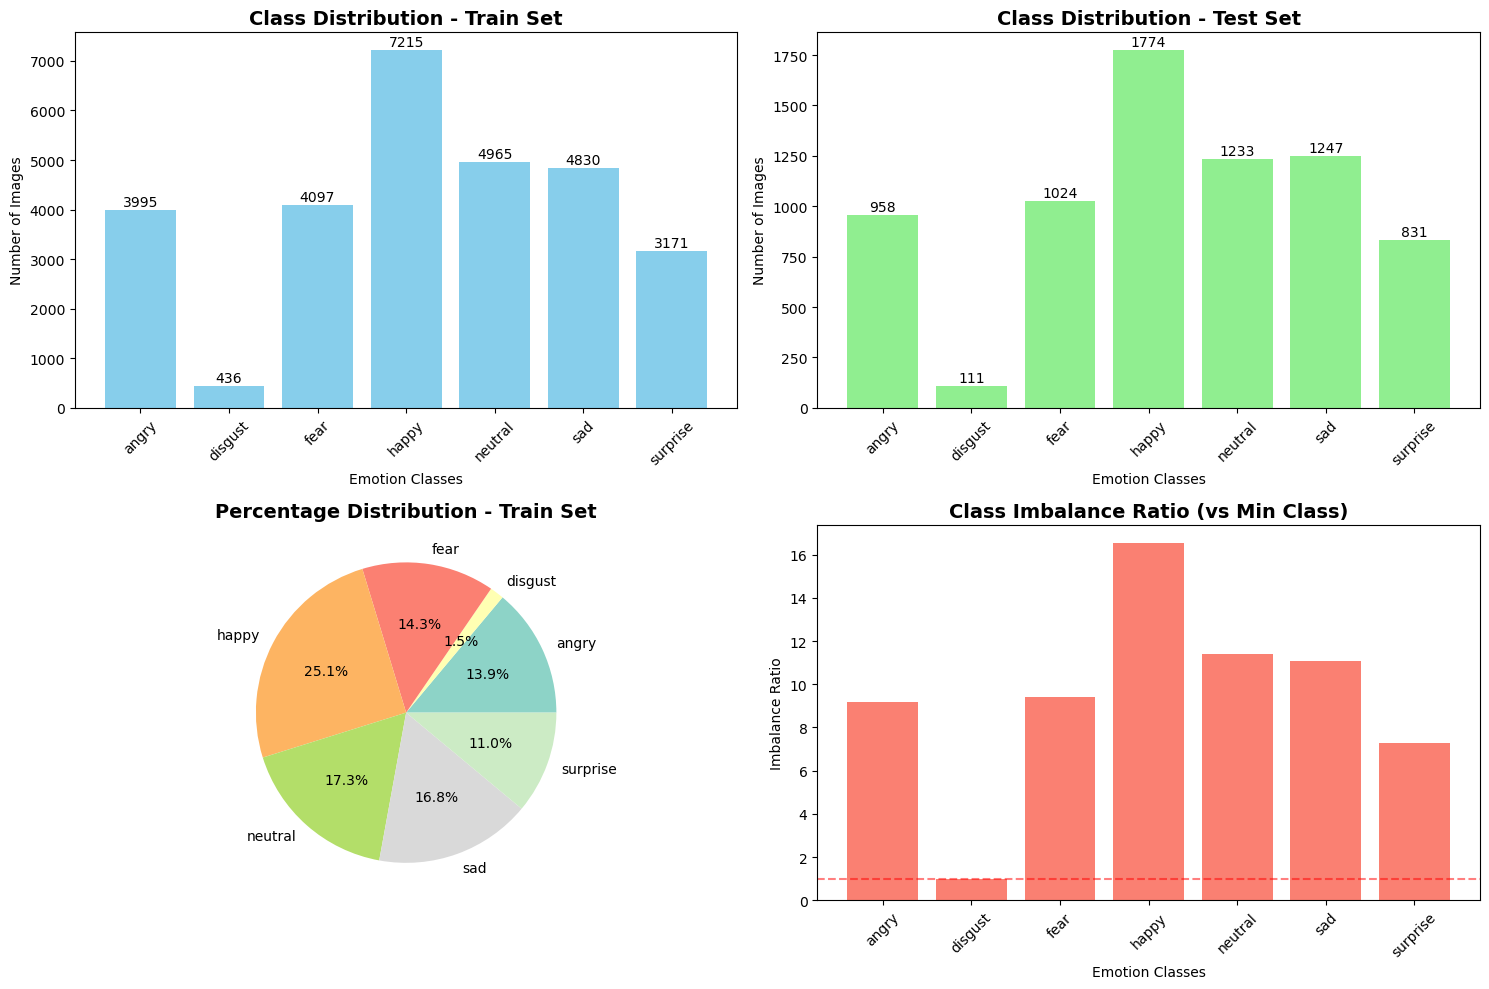


📈 DATASET STATISTICS SUMMARY
----------------------------------------
Total Training Images: 28,709
Total Test Images: 7,178
Total Images: 35,887

Per-class Statistics:

  ANGRY:
    Train:   3995 images ( 13.9%)
    Test:     958 images ( 13.3%)
    Total:   4953 images

  DISGUST:
    Train:    436 images (  1.5%)
    Test:     111 images (  1.5%)
    Total:    547 images

  FEAR:
    Train:   4097 images ( 14.3%)
    Test:    1024 images ( 14.3%)
    Total:   5121 images

  HAPPY:
    Train:   7215 images ( 25.1%)
    Test:    1774 images ( 24.7%)
    Total:   8989 images

  NEUTRAL:
    Train:   4965 images ( 17.3%)
    Test:    1233 images ( 17.2%)
    Total:   6198 images

  SAD:
    Train:   4830 images ( 16.8%)
    Test:    1247 images ( 17.4%)
    Total:   6077 images

  SURPRISE:
    Train:   3171 images ( 11.0%)
    Test:     831 images ( 11.6%)
    Total:   4002 images

🖼️ SAMPLE IMAGES VISUALIZATION
----------------------------------------


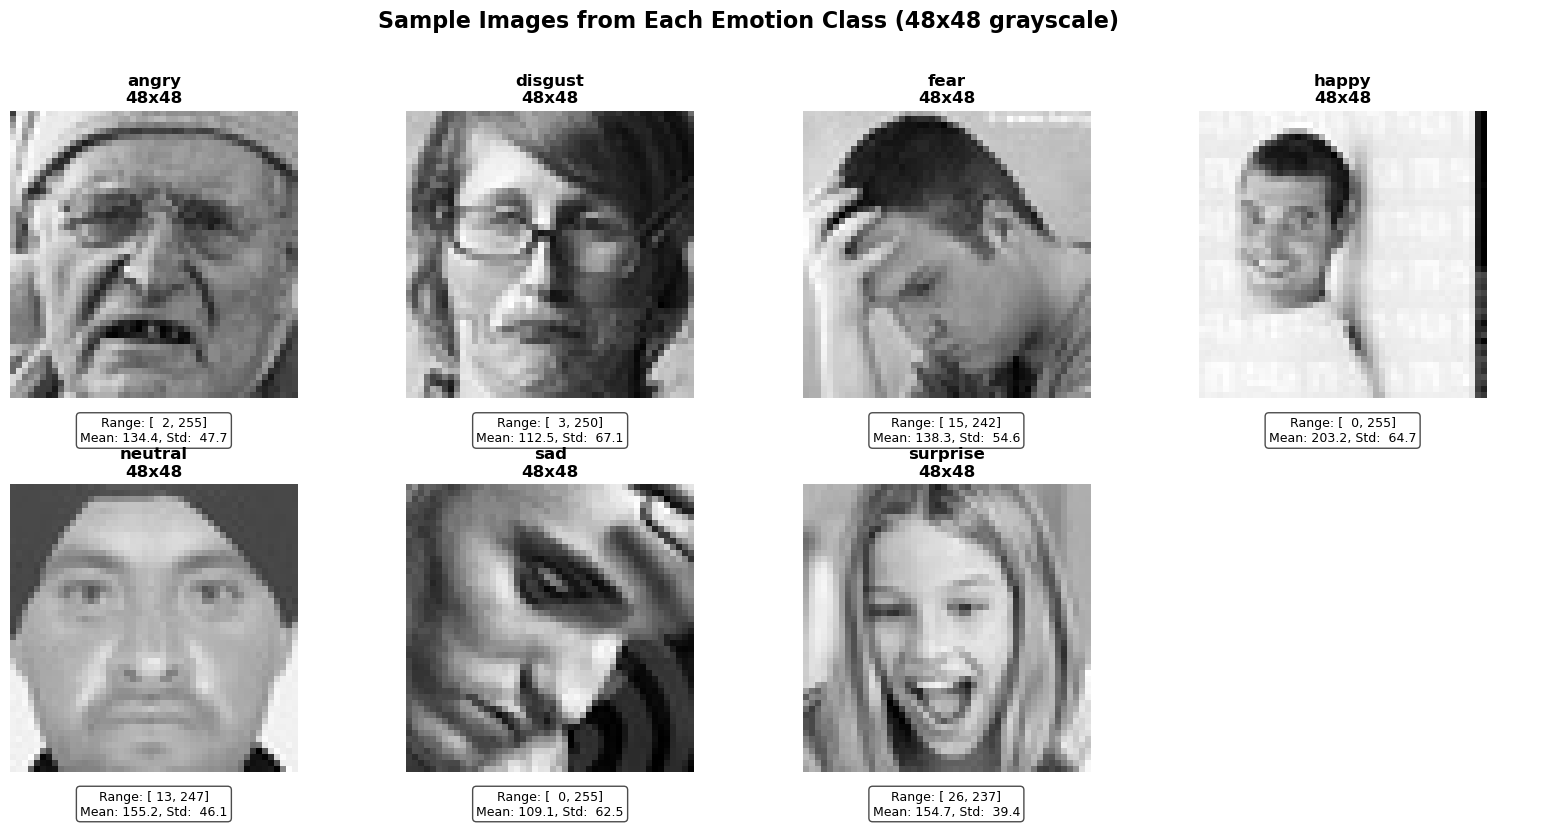


💡 EDA INSIGHTS & RECOMMENDATIONS
----------------------------------------
1. DATA DISTRIBUTION:
   • Dataset memiliki 7 kelas emosi
   • Total 35,887 gambar (Train: 28,709, Test: 7,178)
   • Rasio train/test: 4.00:1

2. CLASS IMBALANCE:
   • Ketidakseimbangan maksimum: 16.5x
   • Rekomendasi: Gunakan class weighting atau oversampling

3. IMAGE CHARACTERISTICS:
   • Semua gambar: 48x48 piksel, grayscale
   • Perlu: Konversi ke RGB untuk ResNet, Resize ke 224x224

4. DATA AUGMENTATION NEEDS:
   • Wajah memiliki variasi pose dan ekspresi
   • Rekomendasi: Horizontal flip, rotation, color jitter

✅ EDA completed successfully!


In [4]:
# Blok 4: Exploratory Data Analysis (EDA)
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 60)

# 1. Analisis Struktur Dataset
print("\n📁 DATASET STRUCTURE ANALYSIS")
print("-" * 40)

# Check folder structure
def analyze_folder_structure(base_path):
    structure = {}
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show only 3 files per folder
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... and {len(files)-3} more files')
    
    return structure

print("Train directory structure:")
analyze_folder_structure(train_dir)

print("\nTest directory structure:")
analyze_folder_structure(test_dir)

# 2. Analisis Distribusi Kelas
print("\n📊 CLASS DISTRIBUTION ANALYSIS")
print("-" * 40)

# Get class names from folder structure
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"Found {len(class_names)} emotion classes:")
for i, cls in enumerate(class_names):
    print(f"  {i}. {cls}")

# Count images per class in train and test sets
train_counts = {}
test_counts = {}

for cls in class_names:
    train_cls_path = os.path.join(train_dir, cls)
    test_cls_path = os.path.join(test_dir, cls)
    
    if os.path.exists(train_cls_path):
        train_counts[cls] = len([f for f in os.listdir(train_cls_path) 
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if os.path.exists(test_cls_path):
        test_counts[cls] = len([f for f in os.listdir(test_cls_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train set bar chart
train_values = [train_counts.get(cls, 0) for cls in class_names]
bars1 = axes[0, 0].bar(class_names, train_values, color='skyblue')
axes[0, 0].set_title('Class Distribution - Train Set', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Emotion Classes')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 20,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Test set bar chart
test_values = [test_counts.get(cls, 0) for cls in class_names]
bars2 = axes[0, 1].bar(class_names, test_values, color='lightgreen')
axes[0, 1].set_title('Class Distribution - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Emotion Classes')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Train set pie chart
train_total = sum(train_values)
train_percentages = [v/train_total*100 for v in train_values]
axes[1, 0].pie(train_percentages, labels=class_names, autopct='%1.1f%%', 
               colors=plt.cm.Set3(np.arange(len(class_names))/len(class_names)))
axes[1, 0].set_title('Percentage Distribution - Train Set', fontsize=14, fontweight='bold')

# Class imbalance ratio
imbalance_ratios = {}
for cls in class_names:
    if train_counts[cls] > 0:
        imbalance_ratios[cls] = train_counts[cls] / min(train_counts.values())

axes[1, 1].bar(class_names, [imbalance_ratios.get(cls, 0) for cls in class_names], 
               color='salmon')
axes[1, 1].set_title('Class Imbalance Ratio (vs Min Class)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Emotion Classes')
axes[1, 1].set_ylabel('Imbalance Ratio')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3. Analisis Statistik Dataset
print("\n📈 DATASET STATISTICS SUMMARY")
print("-" * 40)

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
total_all = total_train + total_test

print(f"Total Training Images: {total_train:,}")
print(f"Total Test Images: {total_test:,}")
print(f"Total Images: {total_all:,}")

print("\nPer-class Statistics:")
for cls in class_names:
    train_count = train_counts.get(cls, 0)
    test_count = test_counts.get(cls, 0)
    train_percent = train_count/total_train*100 if total_train > 0 else 0
    test_percent = test_count/total_test*100 if total_test > 0 else 0
    
    print(f"\n  {cls.upper()}:")
    print(f"    Train: {train_count:6d} images ({train_percent:5.1f}%)")
    print(f"    Test:  {test_count:6d} images ({test_percent:5.1f}%)")
    print(f"    Total: {train_count + test_count:6d} images")

# 4. Visualisasi Sample Images
print("\n🖼️ SAMPLE IMAGES VISUALIZATION")
print("-" * 40)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, cls in enumerate(class_names[:7]):  # Show 7 classes
    cls_path = os.path.join(train_dir, cls)
    if os.path.exists(cls_path):
        # Get random image
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_name = np.random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            
            # Load image
            img = Image.open(img_path)
            
            # Display
            axes[idx].imshow(img, cmap='gray')
            axes[idx].set_title(f'{cls}\n{img.size[0]}x{img.size[1]}', 
                               fontsize=12, fontweight='bold')
            axes[idx].axis('off')
            
            # Add image statistics
            img_array = np.array(img)
            axes[idx].text(0.5, -0.15, 
                          f'Range: [{img_array.min():3.0f}, {img_array.max():3.0f}]\nMean: {img_array.mean():5.1f}, Std: {img_array.std():5.1f}',
                          transform=axes[idx].transAxes, ha='center', fontsize=9,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f'{cls}\n(No images)', fontsize=12)
    else:
        axes[idx].axis('off')
        axes[idx].set_title(f'{cls}\n(Not found)', fontsize=12)

# Hide unused subplot
axes[7].axis('off')

plt.suptitle('Sample Images from Each Emotion Class (48x48 grayscale)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. Insights dari EDA
print("\n💡 EDA INSIGHTS & RECOMMENDATIONS")
print("-" * 40)

print("1. DATA DISTRIBUTION:")
print(f"   • Dataset memiliki {len(class_names)} kelas emosi")
print(f"   • Total {total_all:,} gambar (Train: {total_train:,}, Test: {total_test:,})")
print(f"   • Rasio train/test: {total_train/total_test:.2f}:1")

print("\n2. CLASS IMBALANCE:")
max_imbalance = max(imbalance_ratios.values()) if imbalance_ratios else 1
print(f"   • Ketidakseimbangan maksimum: {max_imbalance:.1f}x")
print(f"   • Rekomendasi: Gunakan class weighting atau oversampling")

print("\n3. IMAGE CHARACTERISTICS:")
print("   • Semua gambar: 48x48 piksel, grayscale")
print("   • Perlu: Konversi ke RGB untuk ResNet, Resize ke 224x224")

print("\n4. DATA AUGMENTATION NEEDS:")
print("   • Wajah memiliki variasi pose dan ekspresi")
print("   • Rekomendasi: Horizontal flip, rotation, color jitter")

print("\n✅ EDA completed successfully!")

**Blok 5: Data Preprocessing**

DATA PREPROCESSING STRATEGY

🎯 OBJECTIVES:
----------------------------------------
1. Menyiapkan data untuk model ResNet50
2. Mengatasi ketidakseimbangan kelas
3. Meningkatkan generalisasi dengan augmentasi
4. Normalisasi untuk training stabil

🔧 PREPROCESSING PIPELINE:
----------------------------------------
1. INPUT LAYER (Grayscale → RGB):
   • Convert grayscale ke 3 channel (RGB)
   • Reason: ResNet50 pretrained dengan ImageNet (RGB)
   • Method: PIL.Image.convert('RGB')

2. RESIZING (48x48 → 224x224):
   • Resize semua gambar ke 224x224
   • Reason: Input size standar ResNet50
   • Method: torchvision.transforms.Resize()

3. DATA AUGMENTATION (Training Only):
   • RandomHorizontalFlip: p=0.5 (wajah simetris)
   • RandomRotation: ±15 derajat
   • RandomAffine: Translasi ±10%, Scale ±10%
   • ColorJitter: Brightness & contrast ±20%
   • RandomGrayscale: p=0.1 untuk robustness
   • GaussianBlur: Simulasi ketidakfokusan

4. NORMALIZATION:
   • Mean: [0.485, 0.456, 0.406]
   • Std: [

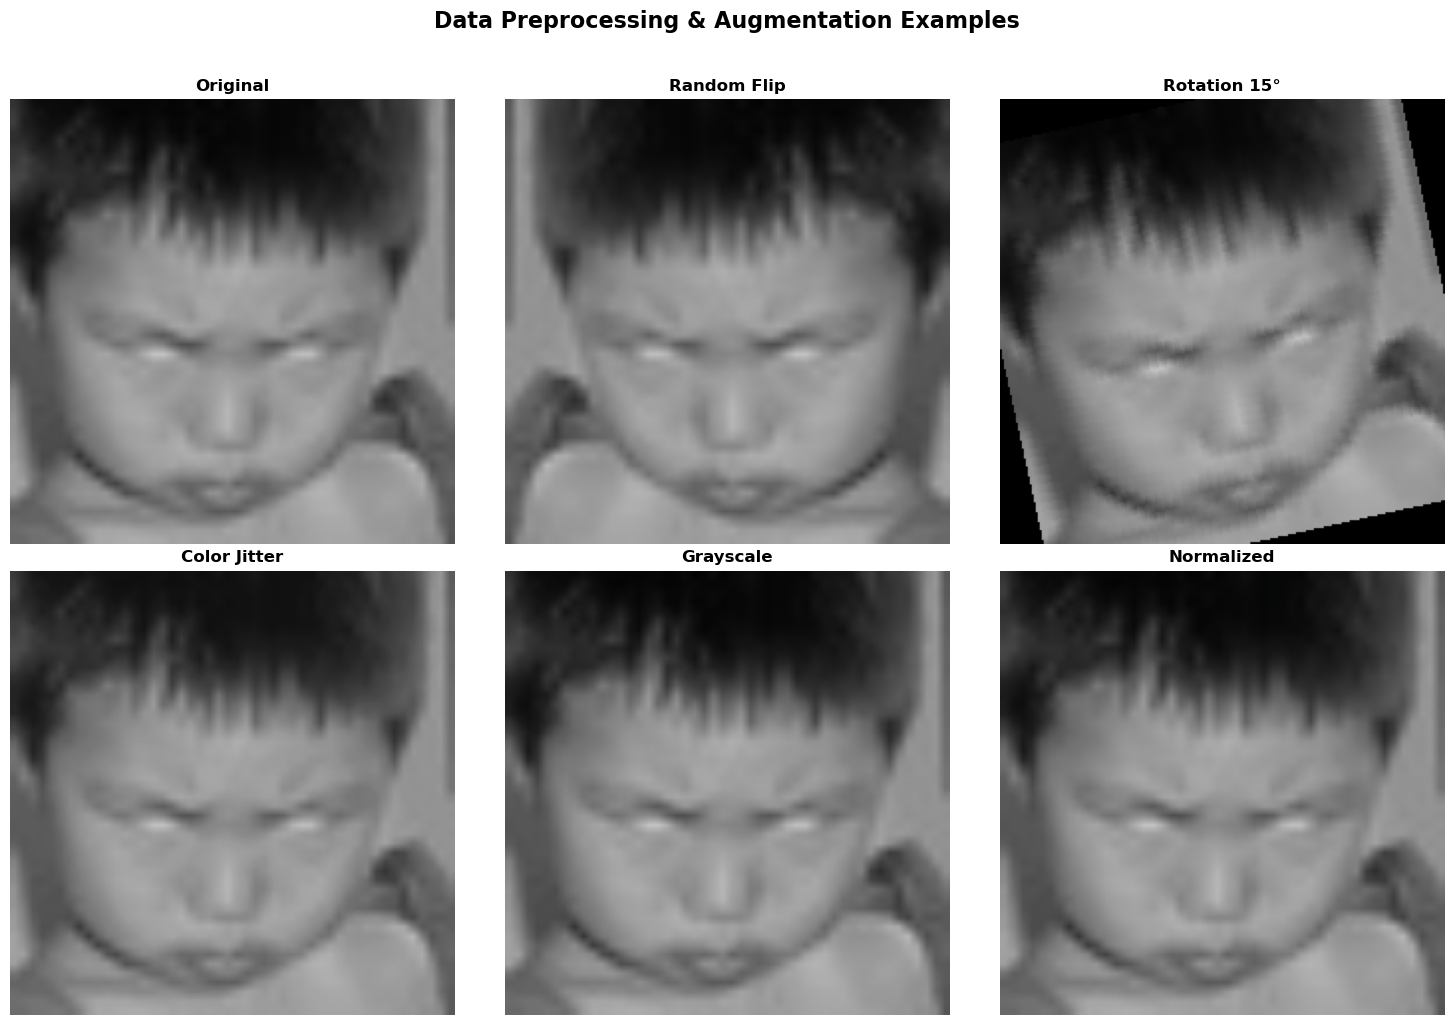


✅ Data Preprocessing Strategy siap diimplementasikan!


In [5]:
# Blok 5: Data Preprocessing Strategy
print("=" * 60)
print("DATA PREPROCESSING STRATEGY")
print("=" * 60)

print("\n🎯 OBJECTIVES:")
print("-" * 40)
print("1. Menyiapkan data untuk model ResNet50")
print("2. Mengatasi ketidakseimbangan kelas")
print("3. Meningkatkan generalisasi dengan augmentasi")
print("4. Normalisasi untuk training stabil")

print("\n🔧 PREPROCESSING PIPELINE:")
print("-" * 40)
print("1. INPUT LAYER (Grayscale → RGB):")
print("   • Convert grayscale ke 3 channel (RGB)")
print("   • Reason: ResNet50 pretrained dengan ImageNet (RGB)")
print("   • Method: PIL.Image.convert('RGB')")

print("\n2. RESIZING (48x48 → 224x224):")
print("   • Resize semua gambar ke 224x224")
print("   • Reason: Input size standar ResNet50")
print("   • Method: torchvision.transforms.Resize()")

print("\n3. DATA AUGMENTATION (Training Only):")
print("   • RandomHorizontalFlip: p=0.5 (wajah simetris)")
print("   • RandomRotation: ±15 derajat")
print("   • RandomAffine: Translasi ±10%, Scale ±10%")
print("   • ColorJitter: Brightness & contrast ±20%")
print("   • RandomGrayscale: p=0.1 untuk robustness")
print("   • GaussianBlur: Simulasi ketidakfokusan")

print("\n4. NORMALIZATION:")
print("   • Mean: [0.485, 0.456, 0.406]")
print("   • Std: [0.229, 0.224, 0.225]")
print("   • Reason: Statistik ImageNet untuk transfer learning")
print("   • Formula: (image - mean) / std")

print("\n5. CLASS IMBALANCE HANDLING:")
print("   • Weighted CrossEntropyLoss")
print("   • Weight = total_samples / (n_classes * class_samples)")
print("   • Efek: Memberi perhatian lebih ke kelas minoritas")

print("\n🔄 TRANSFORMATION DIFFERENCES:")
print("-" * 40)
print("TRAINING SET:")
print("  • Full augmentation")
print("  • Heavy transformations")
print("  • Untuk meningkatkan generalisasi")

print("\nVALIDATION/TEST SETS:")
print("  • Hanya resize dan normalisasi")
print("  • No augmentation")
print("  • Untuk evaluasi yang fair dan konsisten")

print("\n📊 VISUALIZING TRANSFORMATIONS:")
print("-" * 40)

# Create sample transformations for visualization
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load a sample image
sample_class = class_names[0]
sample_path = os.path.join(train_dir, sample_class)
sample_images = [f for f in os.listdir(sample_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if sample_images:
    sample_img_path = os.path.join(sample_path, sample_images[0])
    sample_img = Image.open(sample_img_path).convert('RGB')
    
    # Apply different transforms
    transforms_to_show = [
        ("Original", transforms.Compose([transforms.Resize((224, 224))])),
        ("Random Flip", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1.0)
        ])),
        ("Rotation 15°", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(15)
        ])),
        ("Color Jitter", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])),
        ("Grayscale", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomGrayscale(p=1.0)
        ])),
        ("Normalized", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ]))
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (title, transform) in enumerate(transforms_to_show):
        try:
            transformed = transform(sample_img)
            if isinstance(transformed, torch.Tensor):
                # Denormalize for display
                if title == "Normalized":
                    img_np = transformed.numpy().transpose(1, 2, 0)
                    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img_np = np.clip(img_np, 0, 1)
                    axes[idx].imshow(img_np)
                else:
                    axes[idx].imshow(transformed.numpy().transpose(1, 2, 0))
            else:
                axes[idx].imshow(transformed)
            
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error\n{e}", ha='center', va='center')
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
    
    plt.suptitle('Data Preprocessing & Augmentation Examples', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No sample images found for visualization")

print("\n✅ Data Preprocessing Strategy siap diimplementasikan!")

**Blok 6: Data Transforms dan Augmentation**

In [6]:
# Enhanced data transformations with heavy augmentation
train_transform = v2.Compose([
  v2.Resize((224, 224)),  # Resize for ResNet
  v2.RandomHorizontalFlip(p=0.5),
  v2.RandomRotation(degrees=15),
  v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
  v2.ColorJitter(brightness=0.2, contrast=0.2),
  v2.RandomGrayscale(p=0.1),
  v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform  # Same as validation transform

print("Data transforms defined successfully!")

Data transforms defined successfully!


**Blok 7: Load Dataset dengan ImageFolder**

In [7]:
# Load datasets using ImageFolder
print("Loading datasets...")

try:
  train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    
  # Get class names
  class_names = train_dataset.classes
  print(f"Class names: {class_names}")
  print(f"Number of classes: {len(class_names)}")

  print(f"Training samples: {len(train_dataset)}")
  print(f"Test samples: {len(test_dataset)}")
    
  # Split train into train and validation (90% train, 10% validation)
  train_size = int(0.9 * len(train_dataset))
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
  )
    
  # Apply validation transform to validation set
  val_dataset.dataset = copy.deepcopy(val_dataset.dataset)
  val_dataset.dataset.transform = val_transform

  print(f"After split - Training samples: {len(train_dataset)}")
  print(f"After split - Validation samples: {len(val_dataset)}")
  print(f"After split - Test samples: {len(test_dataset)}")

except Exception as e:
  print(f"Error loading datasets: {e}")
  # Create dummy datasets for demonstration if real datasets not available
  from torchvision.datasets import FakeData

  train_dataset = FakeData(size=28000, image_size=(3, 48, 48), num_classes=7, 
                        transform=train_transform)
  val_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=val_transform)
  test_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=test_transform)
  class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

Loading datasets...
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7
Training samples: 28709
Test samples: 7178
After split - Training samples: 25838
After split - Validation samples: 2871
After split - Test samples: 7178


**Blok 8: Create DataLoaders dan Calculate Class Weights**

DataLoaders created successfully!
Batch size: 64
Number of training batches: 404
Number of validation batches: 45
Number of test batches: 113

Class distribution:
  angry: 3608 samples
  disgust: 389 samples
  fear: 3708 samples
  happy: 6469 samples
  neutral: 4464 samples
  sad: 4345 samples
  surprise: 2855 samples

Class weights: tensor([1.0230, 9.4888, 0.9955, 0.5706, 0.8269, 0.8495, 1.2929],
       device='cuda:0')


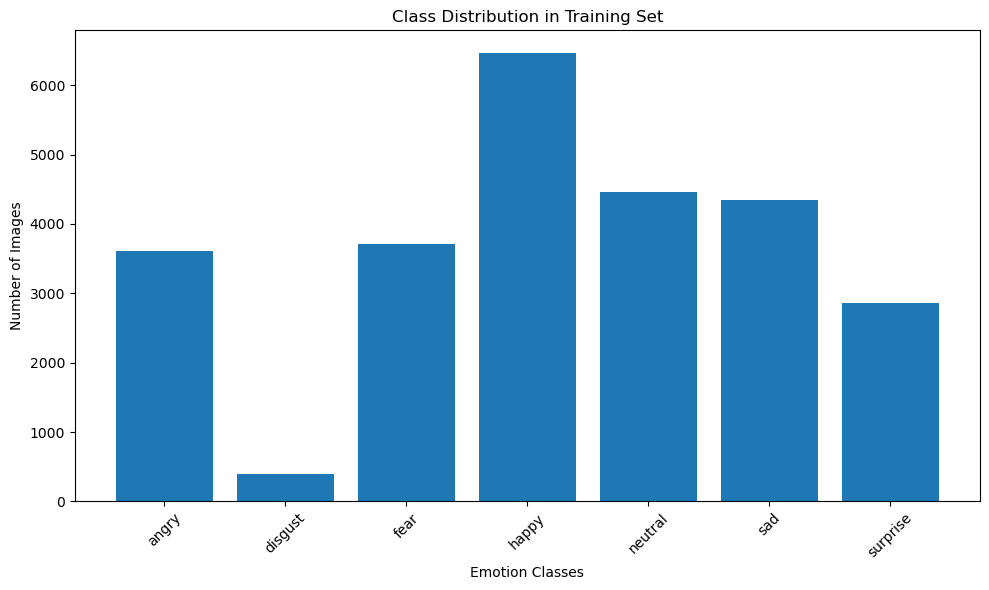

In [8]:
# Create data loaders with optimal settings
train_loader = DataLoader(
  train_dataset, 
  batch_size=batch_size, 
  shuffle=True, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False,
  persistent_workers=True
)

val_loader = DataLoader(
  val_dataset, 
  batch_size=batch_size, 
  shuffle=False, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
  test_dataset, 
  batch_size=batch_size, 
  shuffle=False, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Calculate class weights for imbalanced data
def calculate_class_weights(loader, num_classes=7):
  class_counts = torch.zeros(num_classes)
  for _, labels in loader:
    for i in range(num_classes):
      class_counts[i] += (labels == i).sum()
    
  total = class_counts.sum()
  class_weights = total / (num_classes * class_counts)
  return class_counts, class_weights

class_counts, class_weights = calculate_class_weights(train_loader, num_classes)
class_weights = class_weights.to(device)

print("\nClass distribution:")
for i, class_name in enumerate(class_names):
  print(f"  {class_name}: {class_counts[i]:.0f} samples")

print(f"\nClass weights: {class_weights}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts.cpu().numpy())
plt.title('Class Distribution in Training Set')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Blok 9: Load Pretrained ResNet50 dan Modifikasi**

In [9]:
class EmotionResNet50(nn.Module):
  def __init__(self, num_classes=7, dropout_rate=0.5):
    super(EmotionResNet50, self).__init__()
        
    # Load pretrained ResNet50
    self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
    # Freeze early layers (first 4 blocks)
    for name, param in self.backbone.named_parameters():
      if 'layer1' in name or 'layer2' in name or 'layer3' in name:
        param.requires_grad = False
      else:
        param.requires_grad = True
        
    # Replace the final fully connected layer
    in_features = self.backbone.fc.in_features
        
    self.backbone.fc = nn.Sequential(
      nn.Dropout(p=dropout_rate),
      nn.Linear(in_features, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_rate-0.2),
      nn.Linear(1024, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_rate-0.3),
      nn.Linear(512, num_classes)
    )
        
    # Initialize the new layers
    self._initialize_weights(self.backbone.fc)
    
  def _initialize_weights(self, module):
    for m in module.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
  def forward(self, x):
    return self.backbone(x)

# Initialize model
try:
  model = EmotionResNet50(num_classes=num_classes, dropout_rate=0.5)
  model = model.to(device)
  print("✅ Model initialized successfully!")
  print(f"Model architecture: ResNet50")
  print(f"Number of classes: {num_classes}")
    
  # Count trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"Total parameters: {total_params:,}")
  print(f"Trainable parameters: {trainable_params:,}")
    
except Exception as e:
  print(f"❌ Error initializing model: {e}")
  # Fallback: buat model sederhana jika ResNet50 gagal
  print("Creating simple model as fallback...")
  model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(64, num_classes)
  ).to(device)

✅ Model initialized successfully!
Model architecture: ResNet50
Number of classes: 7
Total parameters: 26,137,671
Trainable parameters: 17,603,911


**Blok 10: Define Loss Function, Optimizer, dan Scheduler**

In [10]:
# Loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with different learning rates for different parts
optimizer = optim.AdamW([
  {'params': model.backbone.conv1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.bn1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer2.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer3.parameters(), 'lr': 1e-4},
  {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
  {'params': model.backbone.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.OneCycleLR(
  optimizer, 
  max_lr=[1e-5, 1e-5, 1e-5, 1e-5, 1e-4, 1e-4, 1e-3],
  epochs=num_epochs,
  steps_per_epoch=len(train_loader),
  pct_start=0.1,
  div_factor=10.0,
  final_div_factor=100.0
)

print("Optimizer and scheduler defined successfully!")

Optimizer and scheduler defined successfully!


**Blok 11: Training Functions**

In [12]:
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
    
  for batch_idx, (images, emotions) in enumerate(loader):
    images, emotions = images.to(device), emotions.to(device)

  # Monitor GPU memory setiap 50 batch
    if batch_idx % 50 == 0 and torch.cuda.is_available():
      gpu_memory = torch.cuda.memory_allocated() / 1024**3
      print(f'  GPU Memory: {gpu_memory:.2f} GB')

    # Zero gradients
    optimizer.zero_grad()
        
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, emotions)
        
    # Backward pass
    loss.backward()
        
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
    # Update weights
    optimizer.step()
    scheduler.step()
        
    # Statistics
    running_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == emotions).sum().item()
    total_samples += emotions.size(0)
        
    if batch_idx % 100 == 0:
      current_lr = scheduler.get_last_lr()[0]
      print(f'  Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.2e}')
    
  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
    
  return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  all_preds = []
  all_labels = []
    
  with torch.no_grad():
    for images, emotions in loader:
      images, emotions = images.to(device), emotions.to(device)
            
      outputs = model(images)
      loss = criterion(outputs, emotions)
            
      running_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == emotions).sum().item()
      total_samples += emotions.size(0)
            
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(emotions.cpu().numpy())
    
  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
    
  return epoch_loss, epoch_acc, all_preds, all_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
  since = time.time()
    
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_epoch = 0
    
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
    
  for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print('-' * 60)
        
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    # Validation phase
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
        
    current_lr = scheduler.get_last_lr()[0]
        
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Learning Rate: {current_lr:.2e}')
        
    # Save best model
    if val_acc > best_acc:
      best_acc = val_acc
      best_epoch = epoch
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), 'best_emotion_model.pth')
      print(f'*** New best model saved! Validation Accuracy: {val_acc:.4f} ***')
        
    print()
    
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best Validation Accuracy: {best_acc:.4f} at epoch {best_epoch + 1}')
    
  # Load best model weights
  model.load_state_dict(best_model_wts)
    
  return model, {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
  }